In [1]:
import torch
import matplotlib.pyplot as plt
from conex import Neocortex, prioritize_behaviors, SimpleDendriteStructure, SimpleDendriteComputation, SpikeTrace, \
    NeuronAxon, SynapseInit, WeightInitializer, SimpleDendriticInput, SimpleSTDP, Fire, WeightClip, LIF, \
    WeightNormalization, KWTA, ActivityBaseHomeostasis, VoltageBaseHomeostasis
from pymonntorch import NeuronGroup, NeuronDimension, SynapseGroup, EventRecorder, Recorder

from models.activity import ActivityRecorder
from models.dendrites import LateralDendriticInput2D, LateralInhibitionDendriticInput
from models.encoders import FeedDataset, CustomPoisson, Poisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar
from models.trace import ClearSpikeTrace
from simulate import Simulation
from utils.dataset import load_data, add_overlap
from utils.formatter import pretty_format_dict
from utils.plots import add_colorized_raset_plot


# Different number of patterns for simple STDP

In [2]:
def default_simulation(encoded_dataset, num_feed, instance_duration, sleep, normalization=True, **kwargs):
    input_layer_parameters = {
        "input_layer_tag":"input_layer",
        "input_layer_tau": 10,
        "input_layer_v_rest": -65.0,
        "input_layer_v_reset": -70.0,
        "input_layer_threshold": -55,
        "input_layer_R": 1.7,
        'input_layer_tau_s':4,
    }
    output_layer_parameters = {
        "output_layer_tag":"output_layer",
        "output_layer_tau": 10,
        "output_layer_v_rest": -65.0,
        "output_layer_v_reset": -70.0,
        "output_layer_threshold": -55,
        "output_layer_R": 1.7,
        'output_layer_tau_s':3
    }
    syn_inp_out_prarameters = {
        'w_max':1,
        'w_min':0,
        'a_plus':0.1,
        'a_minus':0.03,
        'positive_bound':'soft_bound',
        'negative_bound':'soft_bound',
        'weight_mode': 'random',
        'current_coef': 100,
    }
    dataset_parameters = {
        'num_data': dataset.shape[0],
    }
    ALL_PARAMETERS = {
        **input_layer_parameters,
        **output_layer_parameters,
        **syn_inp_out_prarameters,
        **dataset_parameters,
        **kwargs
    }
    sim = Simulation(net=Neocortex(dt=1))
    input_layer = sim.add_neuron_group(
        tag=ALL_PARAMETERS['input_layer_tag'],
        # size=NeuronDimension(depth=1, height=1, width=18),
        size=encoded_dataset.shape[2],
        behavior=prioritize_behaviors(
            [
                SimpleDendriteStructure(),
                SimpleDendriteComputation(),
                LIF(
                    tau=ALL_PARAMETERS["input_layer_tau"],
                    v_rest=ALL_PARAMETERS["input_layer_v_rest"],
                    v_reset=ALL_PARAMETERS["input_layer_v_reset"],
                    threshold=ALL_PARAMETERS["input_layer_threshold"],
                    R=ALL_PARAMETERS["input_layer_R"],
                ),
                SpikeTrace(tau_s=ALL_PARAMETERS['input_layer_tau_s']),
                NeuronAxon(),
            ]
        ),
    )
    input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=SLEEP))
    input_layer.add_behavior(key=350, behavior=ActivityRecorder())
    input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
    input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

    output_layer = sim.add_neuron_group(
        tag=ALL_PARAMETERS['output_layer_tag'],
        size=encoded_dataset.shape[0],
        behavior=prioritize_behaviors(
            [
                SimpleDendriteStructure(),
                SimpleDendriteComputation(),
                LIF(
                    tau=ALL_PARAMETERS["output_layer_tau"],
                    v_rest=ALL_PARAMETERS["output_layer_v_rest"],
                    v_reset=ALL_PARAMETERS["output_layer_v_reset"],
                    threshold=ALL_PARAMETERS["output_layer_threshold"],
                    R=ALL_PARAMETERS["output_layer_R"],
                ),
                Fire(),
                SpikeTrace(tau_s=ALL_PARAMETERS['output_layer_tau_s']),
                NeuronAxon(),
            ]
        ),
    )
    output_layer.add_behavior(key=350, behavior=ActivityRecorder())
    output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
    output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

    syn_inp_out = sim.add_synapse_group(
        src=input_layer,
        dst=output_layer,
        tag="Proximal",
        behavior=prioritize_behaviors(
            [
                SynapseInit(),
                WeightInitializer(mode=ALL_PARAMETERS['weight_mode']),
                SimpleDendriticInput(current_coef=ALL_PARAMETERS['current_coef']),
            ]
        ),
    )
    if normalization:
        syn_inp_out.add_behavior(key=420, behavior=WeightNormalization(), initialize=False)
    syn_inp_out.add_behavior(key=400,
                             behavior=SimpleSTDP(
                                            w_max=ALL_PARAMETERS['w_max'],
                                            w_min=ALL_PARAMETERS['w_min'],
                                            a_plus=ALL_PARAMETERS['a_plus'],
                                            a_minus=ALL_PARAMETERS['a_minus'],
                                            positive_bound=ALL_PARAMETERS['positive_bound'],
                                            negative_bound=ALL_PARAMETERS['negative_bound']),
                             initialize=False
                             )
    syn_inp_out.add_behavior(key=401,
                            behavior=ClearSpikeTrace())
    syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))
    return sim

In [151]:
NUM_DATA = 2
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [153]:
sim1 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.09,
                          a_minus=0.025,
                          current_coef=270)
input_layer = sim1.net.NeuronGroups[0]
output_layer = sim1.net.NeuronGroups[1]
syn_inp_out = sim1.net.SynapseGroups[0]

sim1.initialize()
sim1.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(502)|2 groups, Synapses: tensor(1000)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_2_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True,  True, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


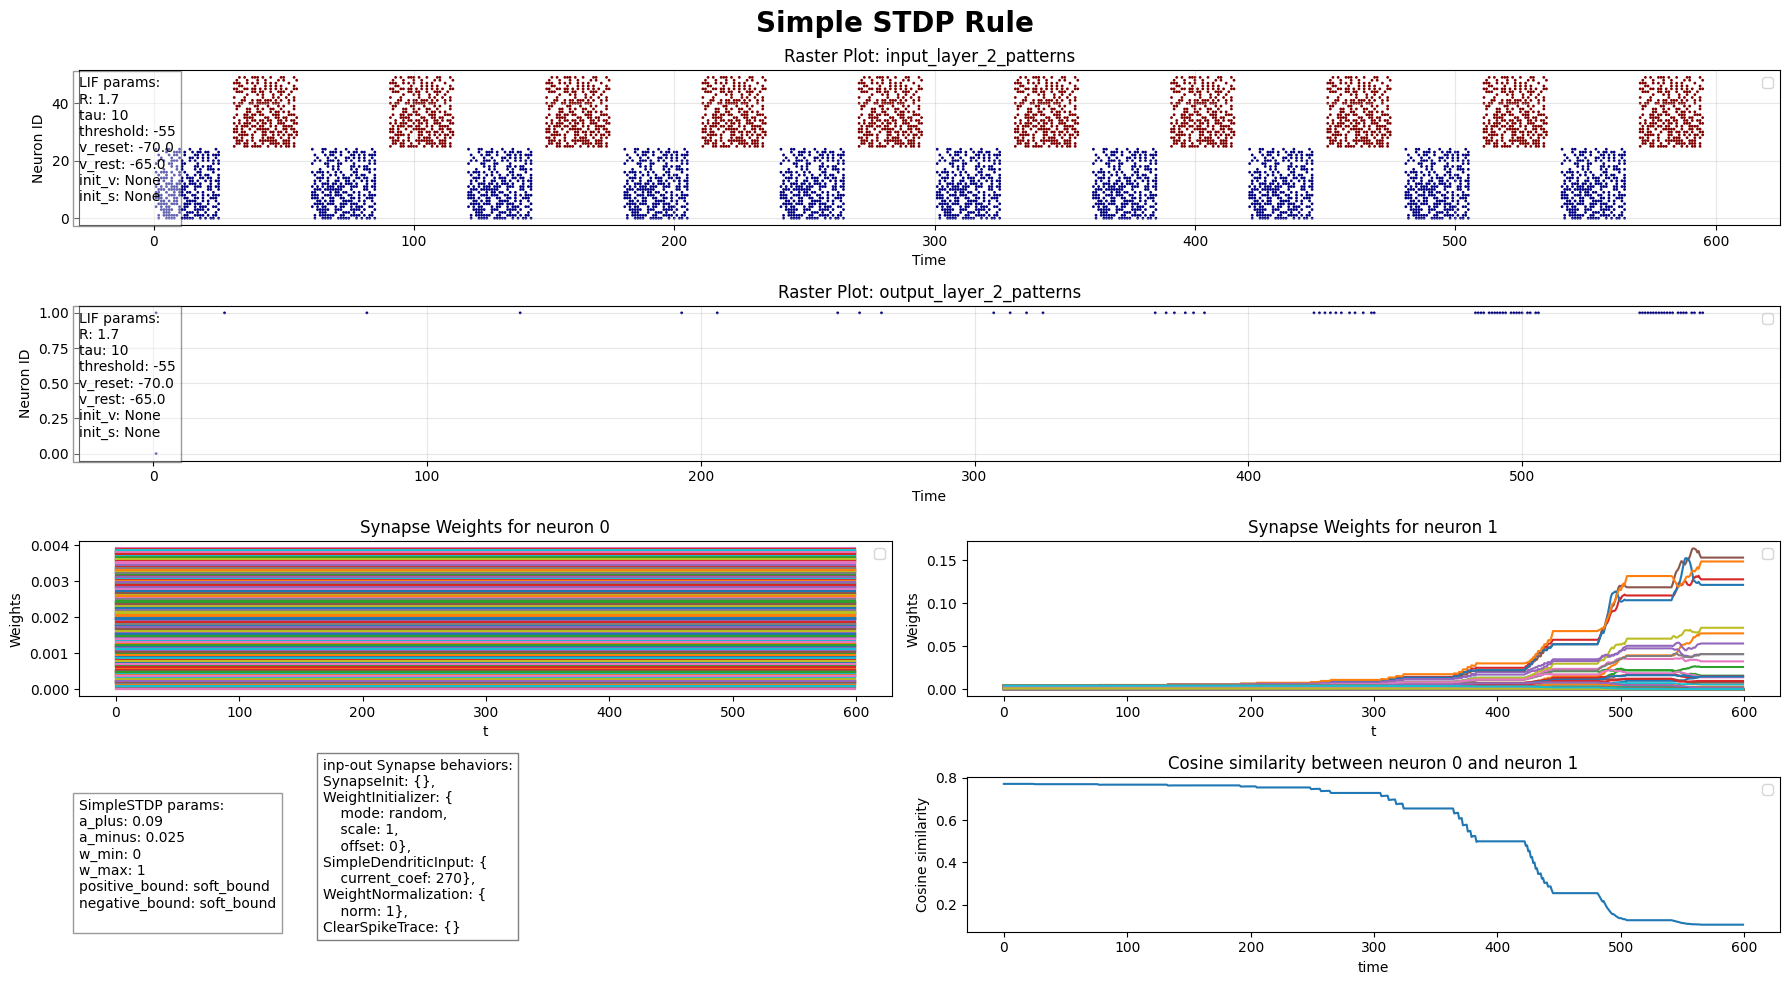

In [154]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

In [86]:
NUM_DATA = 3
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [87]:
sim2 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.04,
                          current_coef=250)
input_layer = sim2.net.NeuronGroups[0]
output_layer = sim2.net.NeuronGroups[1]
syn_inp_out = sim2.net.SynapseGroups[0]
sim2.initialize()
sim2.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(503)|2 groups, Synapses: tensor(1500)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_3_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

In [83]:
NUM_DATA = 5
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA,:]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [84]:
sim3 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.1,
                          a_minus=0.03,
                          current_coef=300)
input_layer = sim3.net.NeuronGroups[0]
output_layer = sim3.net.NeuronGroups[1]
syn_inp_out = sim3.net.SynapseGroups[0]
sim3.initialize()
sim3.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(505)|2 groups, Synapses: tensor(2500)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_5_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


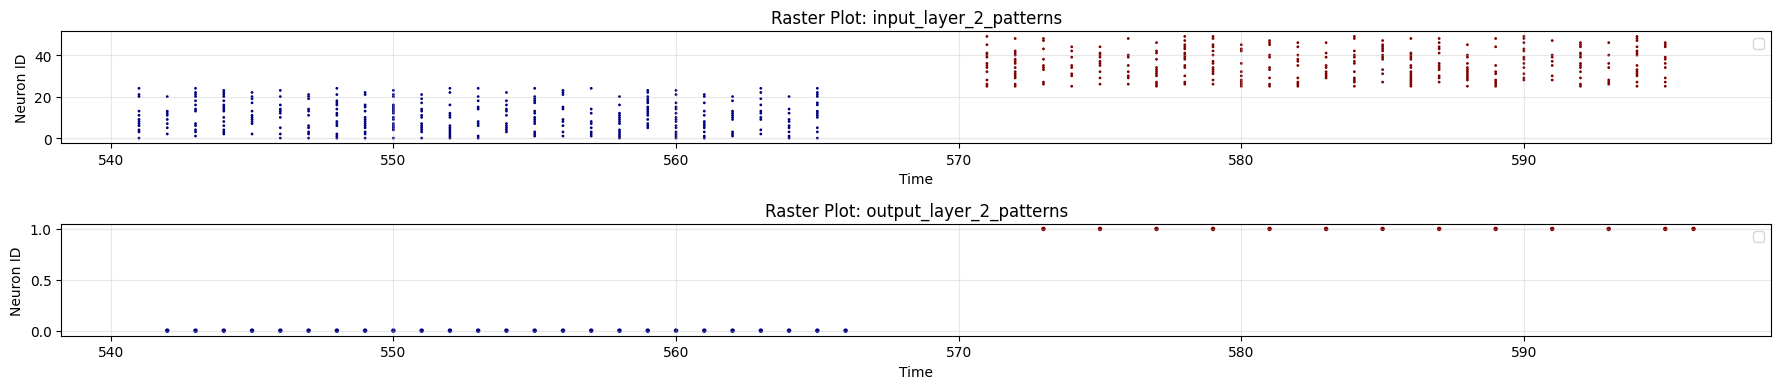

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


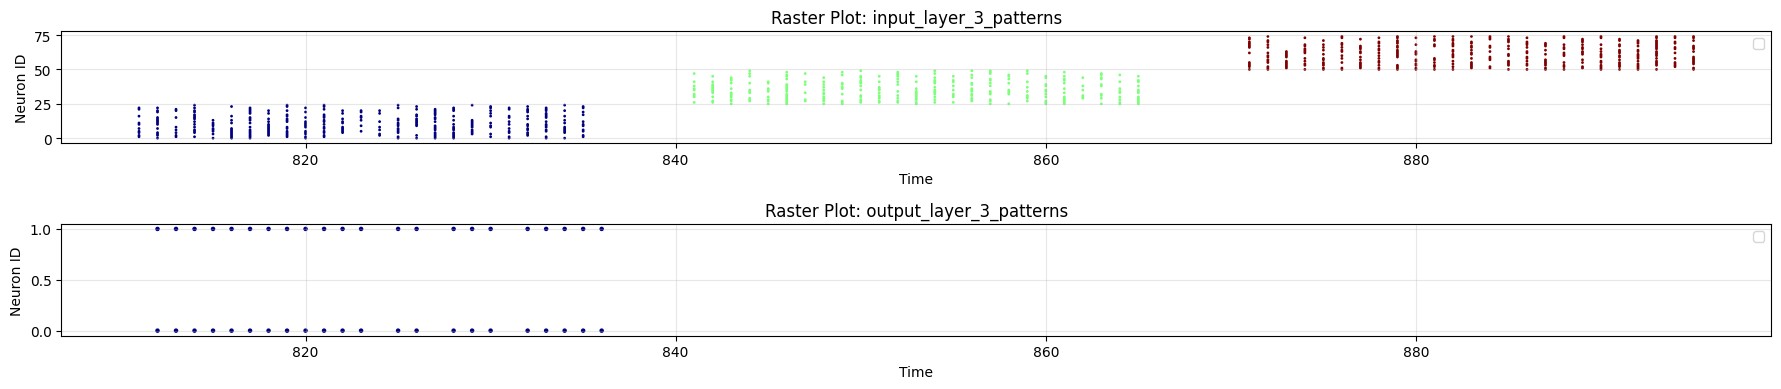

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


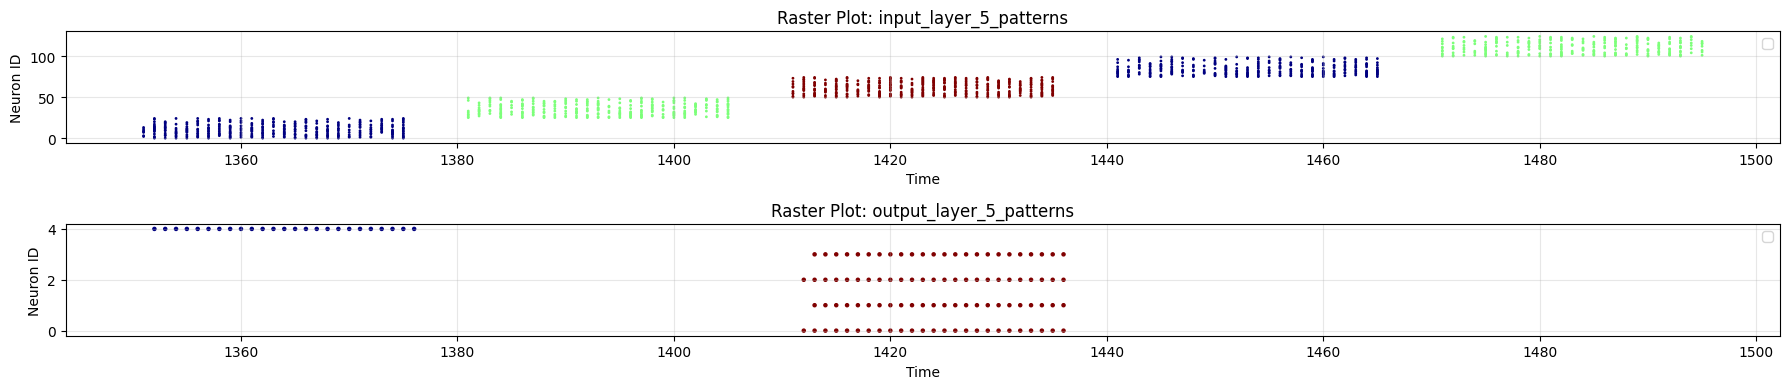

In [99]:

simulations = [sim1, sim2, sim3]
for i, sim in enumerate(simulations):
    fig = plt.figure(figsize=(18, 4))

    output_layer_size = sim.net.NeuronGroups[1].size
    ax1 = fig.add_subplot(2, 1, 1)  # 3 rows, 1 column, first plot
    ax1.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax1, sim.net.NeuronGroups[0], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=1)

    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)  # 3 rows, 1 column, first plot
    ax2.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax2, sim.net.NeuronGroups[1], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)

    # fig.suptitle("Simple STDP on different number of patterns", fontsize=20, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f"../report/plots/with-normalization/part1-evaluation-simple-stdp-{NUM_DATA}-patterns.pdf")
    plt.show()

# Different number of patterns for Lateral Inhibition

In [8]:
NUM_DATA = 2
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [9]:
sim1 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.18,
                          a_minus=0.055,
                          current_coef=350)
input_layer = sim1.net.NeuronGroups[0]
output_layer = sim1.net.NeuronGroups[1]
syn_inp_out = sim1.net.SynapseGroups[0]
syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=150.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))
sim1.initialize()
sim1.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(502)|2 groups, Synapses: tensor(1004)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_2_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False, False,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


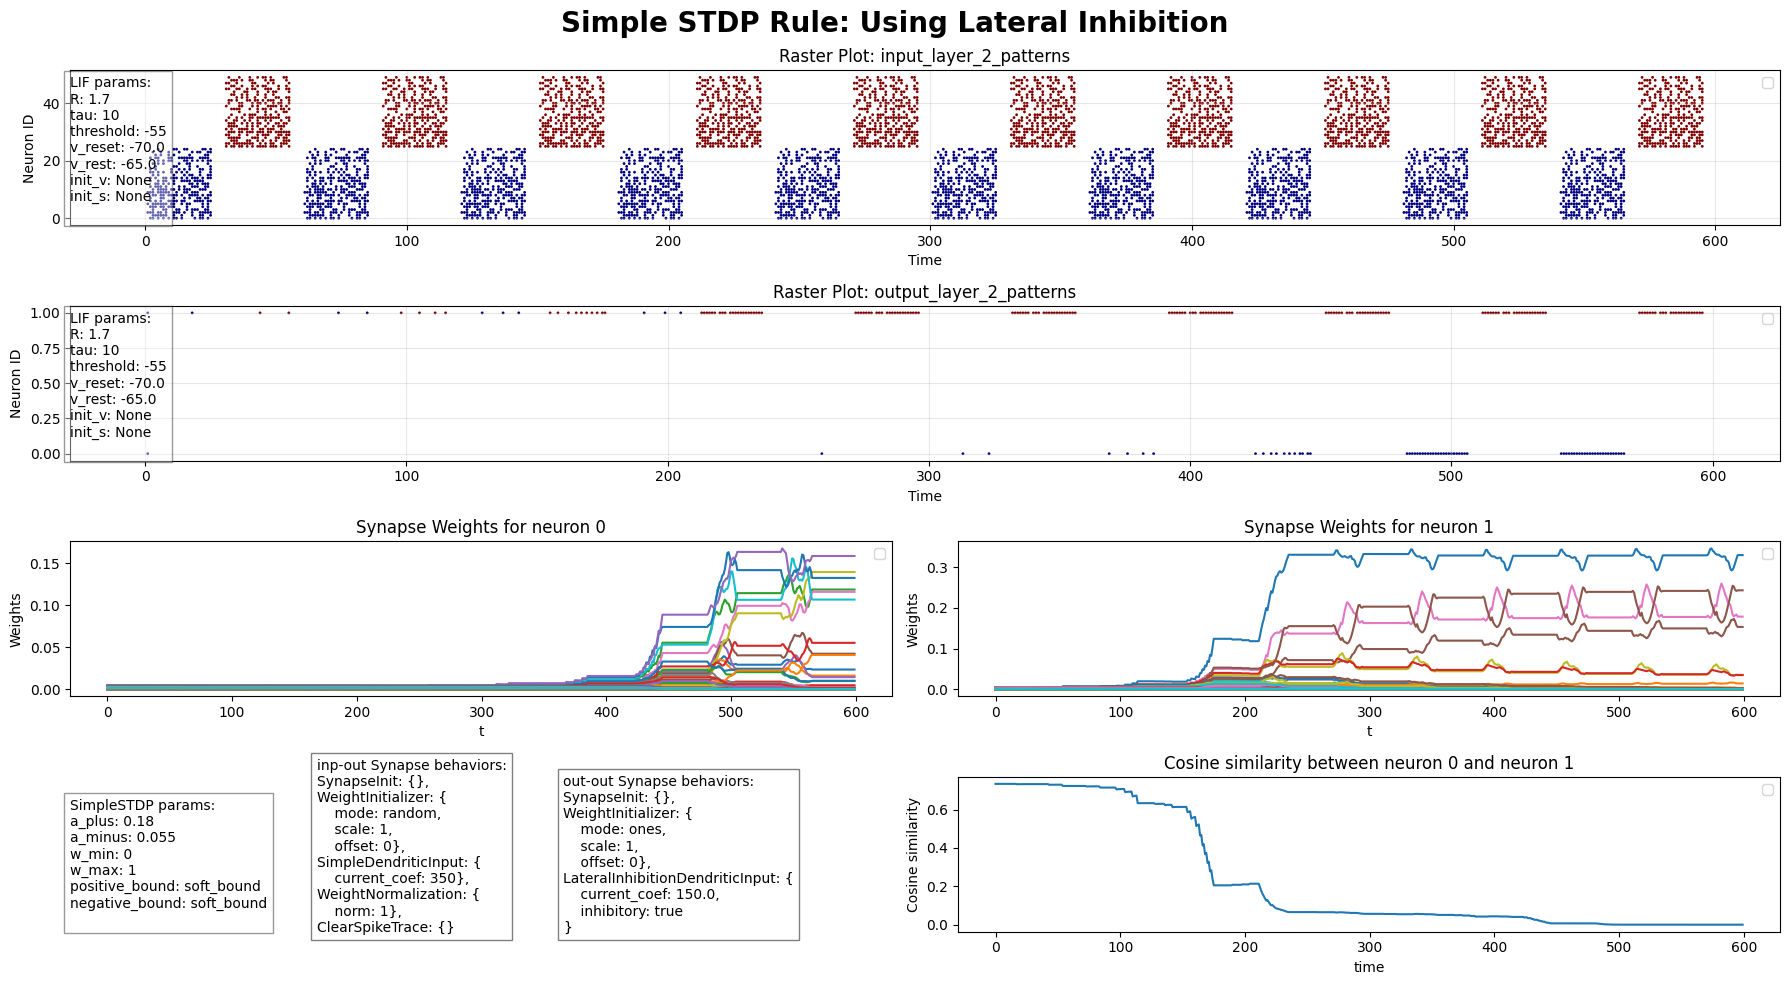

In [10]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using Lateral Inhibition", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

In [40]:
NUM_DATA = 4
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [41]:
sim2 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.035,
                          current_coef=350)
input_layer = sim2.net.NeuronGroups[0]
output_layer = sim2.net.NeuronGroups[1]

syn_inp_out = sim2.net.SynapseGroups[0]
syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=150.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim2.initialize()
sim2.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(504)|2 groups, Synapses: tensor(2016)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_4_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

#### 6 patterns

In [55]:
NUM_DATA = 6
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [56]:
sim3 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.035,
                          current_coef=350)
input_layer = sim3.net.NeuronGroups[0]
output_layer = sim3.net.NeuronGroups[1]

syn_inp_out = sim3.net.SynapseGroups[0]
syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=150.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim3.initialize()
sim3.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(506)|2 groups, Synapses: tensor(3036)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_6_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

#### 8 patterns

In [57]:
NUM_DATA = 8
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [58]:
sim4 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.035,
                          current_coef=350)
input_layer = sim4.net.NeuronGroups[0]
output_layer = sim4.net.NeuronGroups[1]

syn_inp_out = sim4.net.SynapseGroups[0]
syn_out_out = sim4.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=150.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim4.initialize()
sim4.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(508)|2 groups, Synapses: tensor(4064)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_8_patterns', 'CustomNeuronGroup', 'ng'](500){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[ True,  True, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


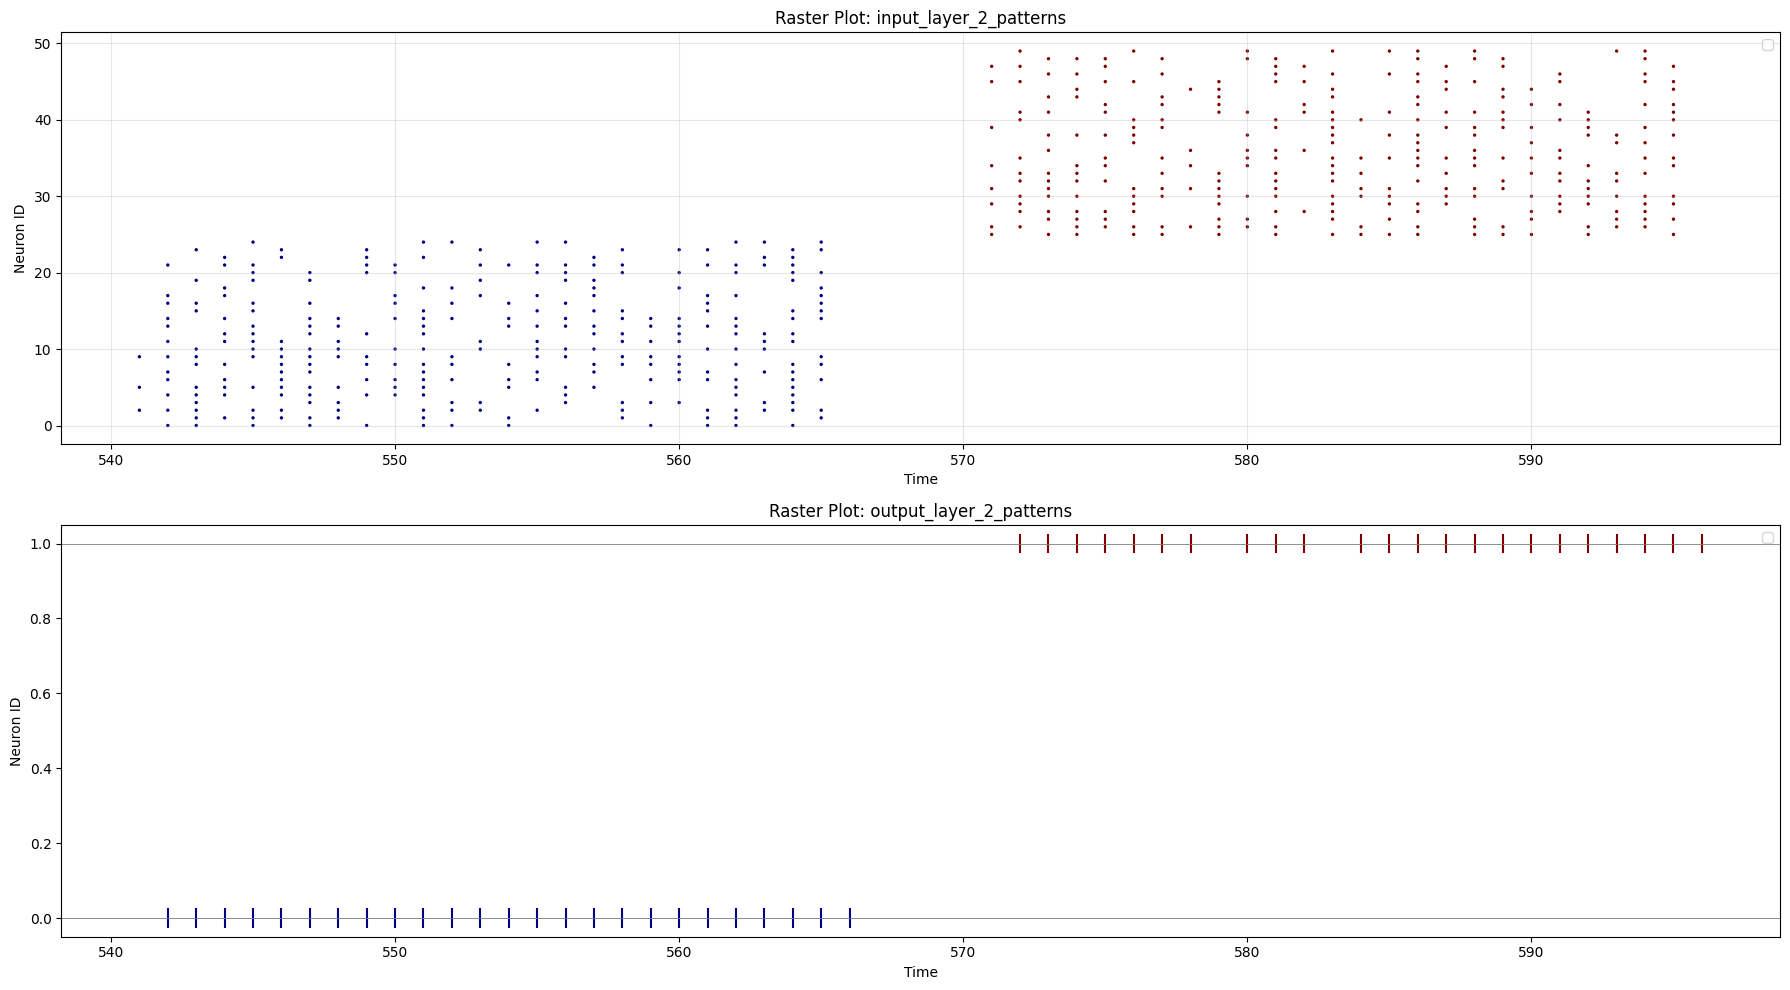

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


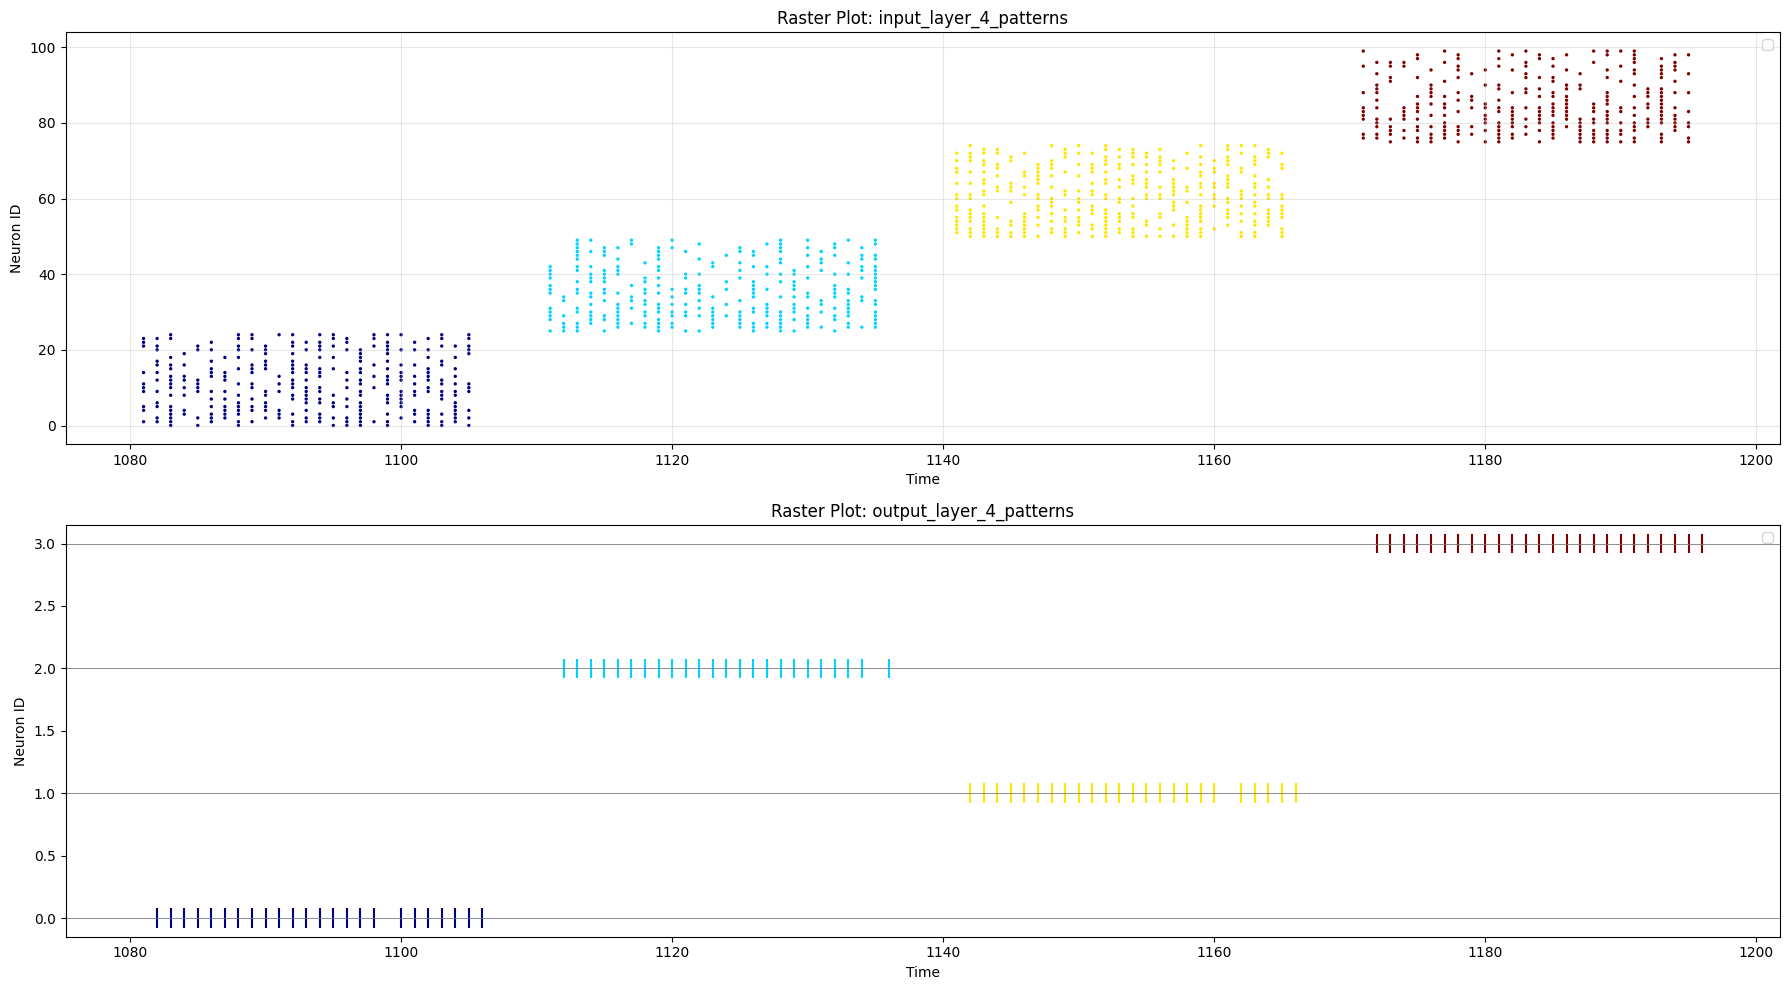

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


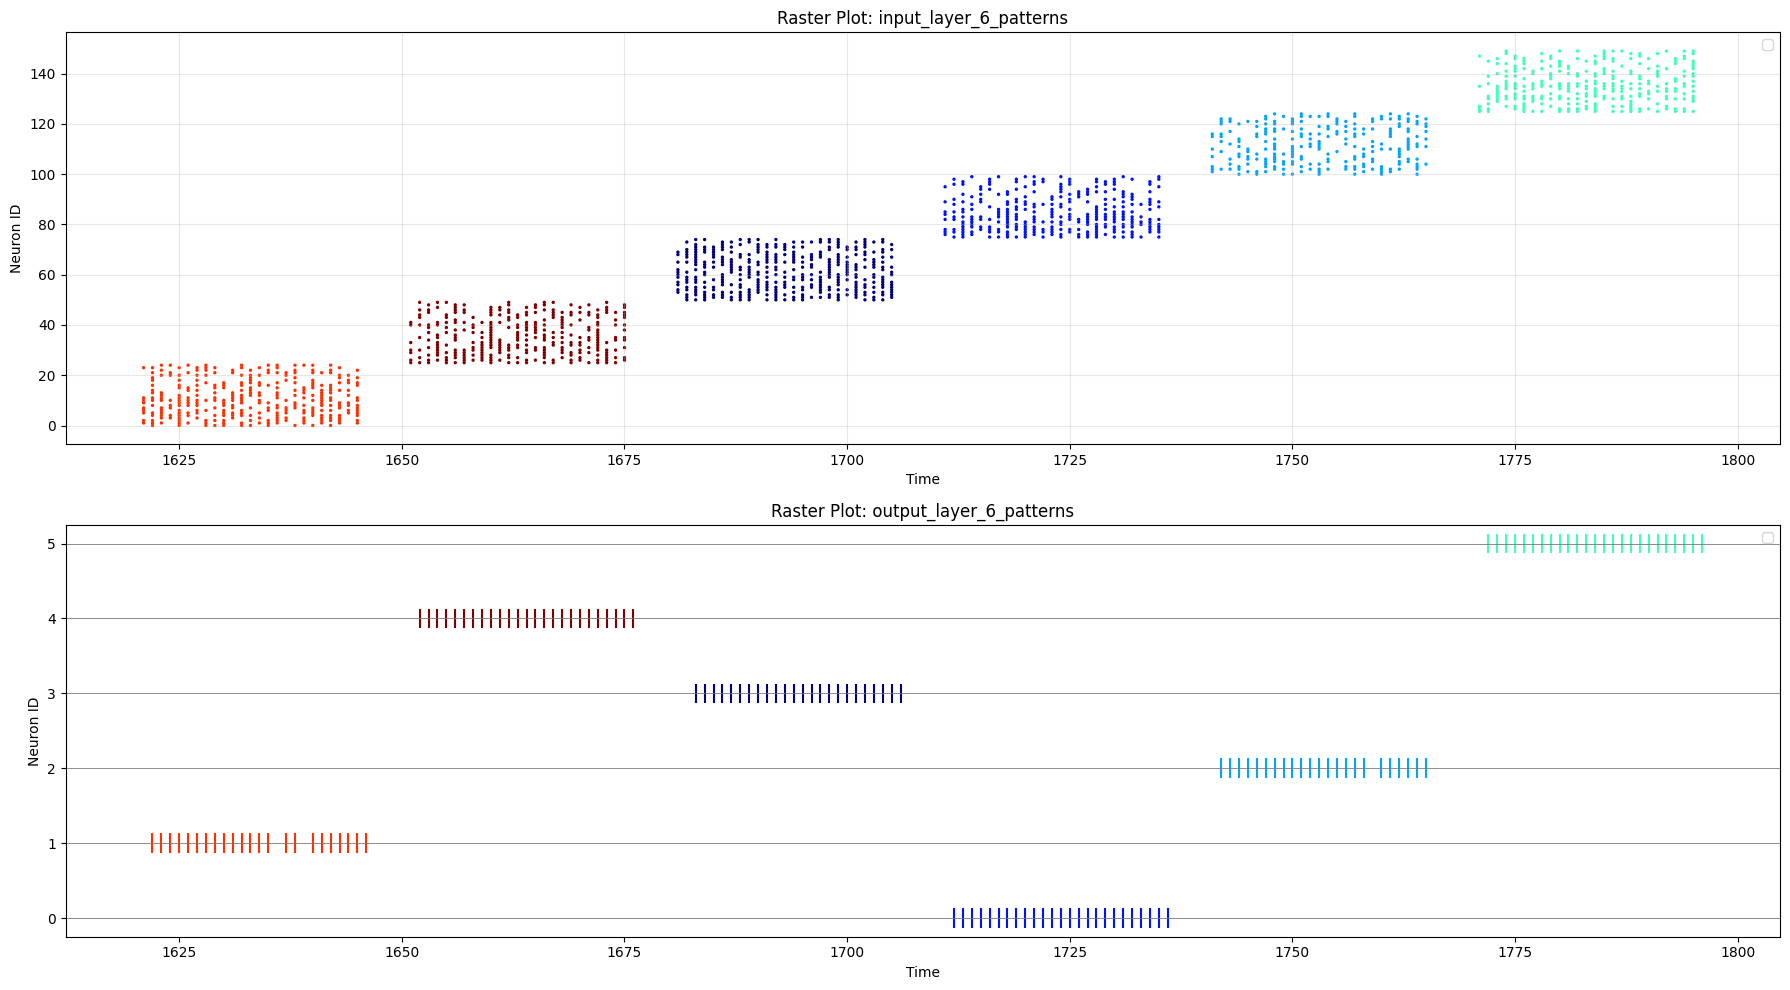

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


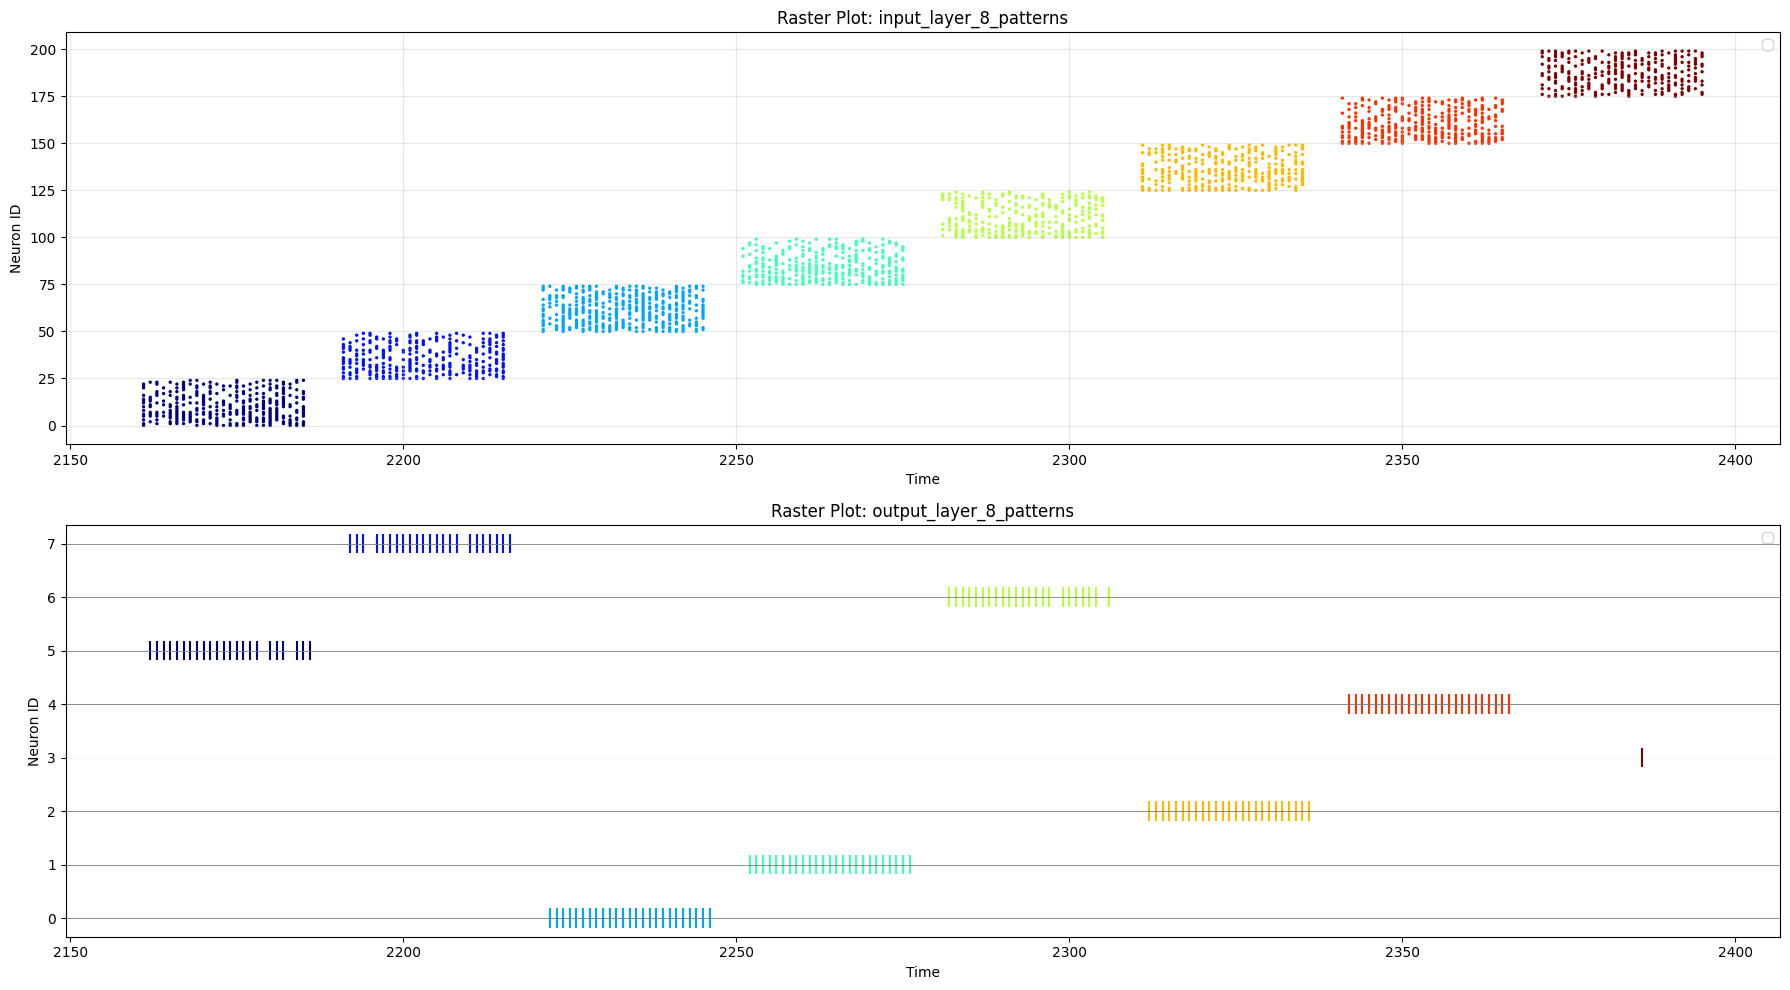

In [72]:
simulations = [sim1, sim2, sim3, sim4]
for i, sim in enumerate(simulations):
    fig = plt.figure(figsize=(18, 10))

    output_layer_size = sim.net.NeuronGroups[1].size
    ax1 = fig.add_subplot(2, 1, 1)  # 3 rows, 1 column, first plot
    ax1.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax1, sim.net.NeuronGroups[0], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=2)

    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)  # 3 rows, 1 column, first plot
    # ax2.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax2, sim.net.NeuronGroups[1], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], axhline=True, marker='|', s=200)

    # fig.suptitle("Simple STDP on different number of patterns", fontsize=20, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f"../report/plots/with-normalization/part1-evaluation-simple-stdp-LI-{output_layer_size}-patterns.pdf")
    plt.show()

# Lateral Inhibition + KWTA

In [189]:
NUM_DATA = 2
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [190]:
sim1 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.12,
                          a_minus=0.035,
                          current_coef=350)
input_layer = sim1.net.NeuronGroups[0]
output_layer = sim1.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)

syn_inp_out = sim1.net.SynapseGroups[0]
syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=200.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim1.initialize()
sim1.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(827)|2 groups, Synapses: tensor(1654)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_2_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


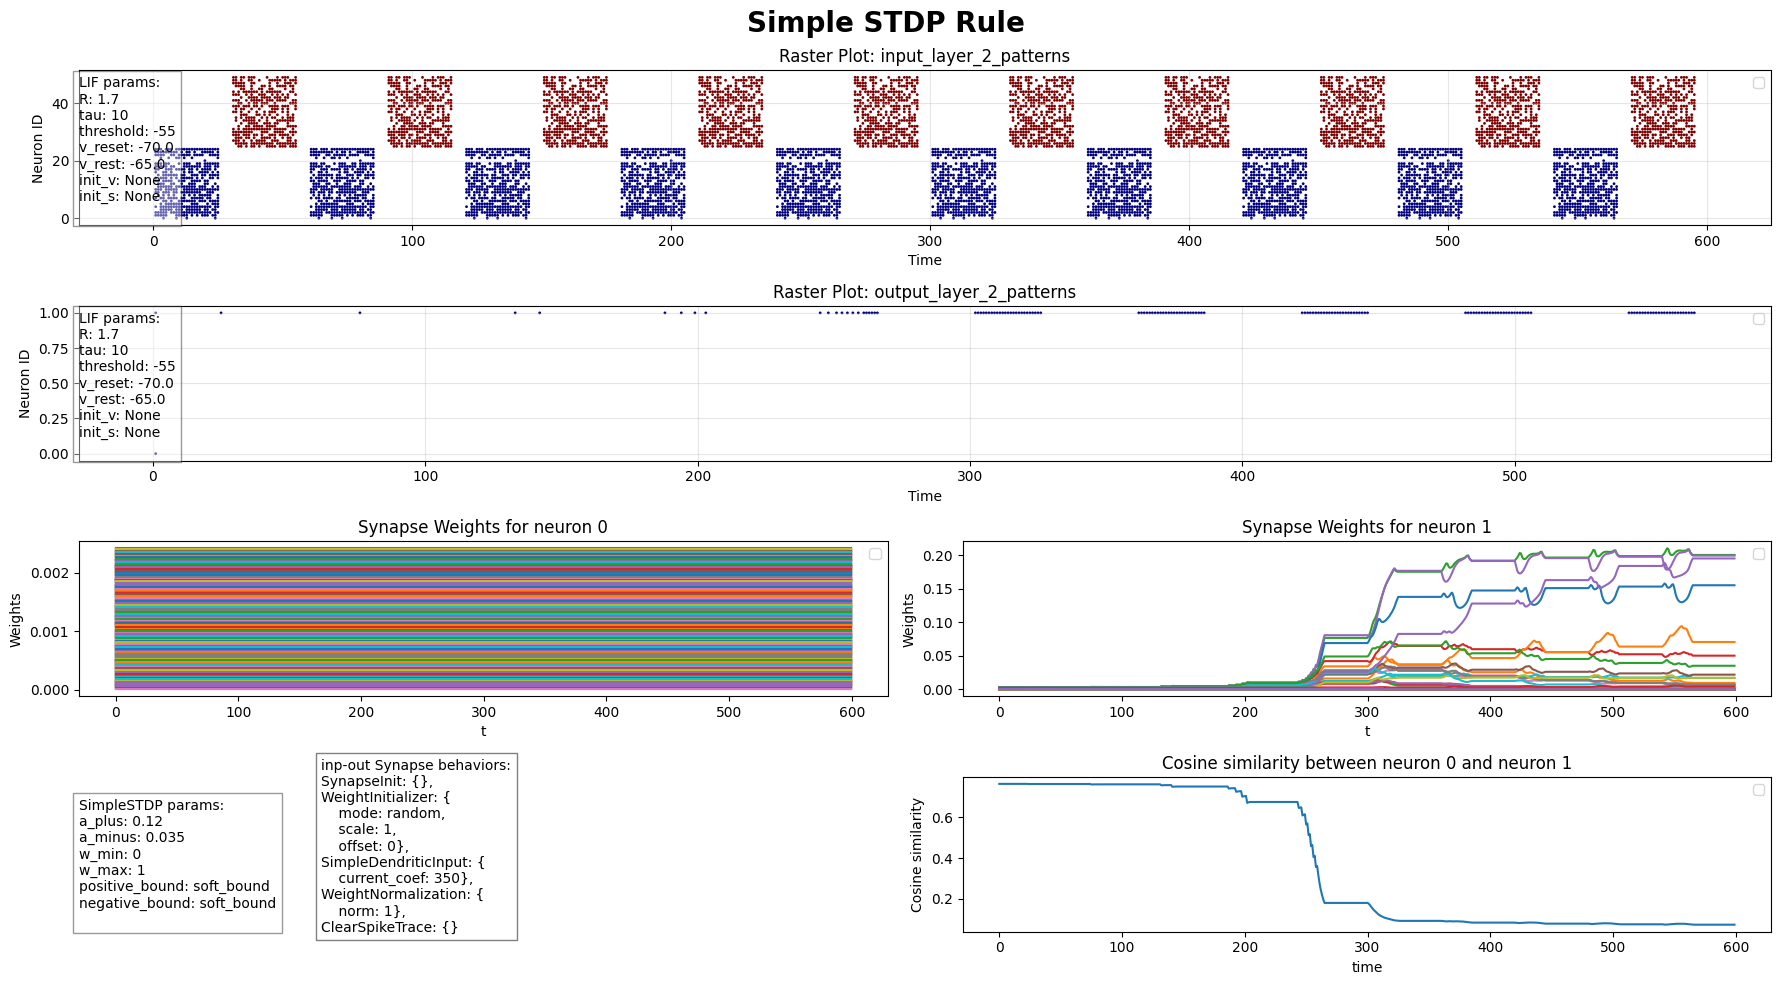

In [191]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

### 5 patterns:

In [192]:
NUM_DATA = 6
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [193]:
sim2 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.12,
                          a_minus=0.035,
                          current_coef=350)
input_layer = sim2.net.NeuronGroups[0]
output_layer = sim2.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)

syn_inp_out = sim2.net.SynapseGroups[0]
syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=200.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim2.initialize()
sim2.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(831)|2 groups, Synapses: tensor(4986)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_6_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

### 10 patterns

In [194]:
NUM_DATA = 10
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [195]:
sim3 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.12,
                          a_minus=0.035,
                          current_coef=350)
input_layer = sim3.net.NeuronGroups[0]
output_layer = sim3.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)

syn_inp_out = sim3.net.SynapseGroups[0]
syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=200.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim3.initialize()
sim3.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(835)|2 groups, Synapses: tensor(8350)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_10_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         ...,
         [False, False,  True,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fal

### 15 patterns

In [212]:
NUM_DATA = 15
NUM_FEED = 8
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [213]:
sim4 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.045,
                          current_coef=300)
input_layer = sim4.net.NeuronGroups[0]
output_layer = sim4.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)

syn_inp_out = sim4.net.SynapseGroups[0]
syn_out_out = sim4.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=250.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim4.initialize()
sim4.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(840)|2 groups, Synapses: tensor(12600)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_15_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


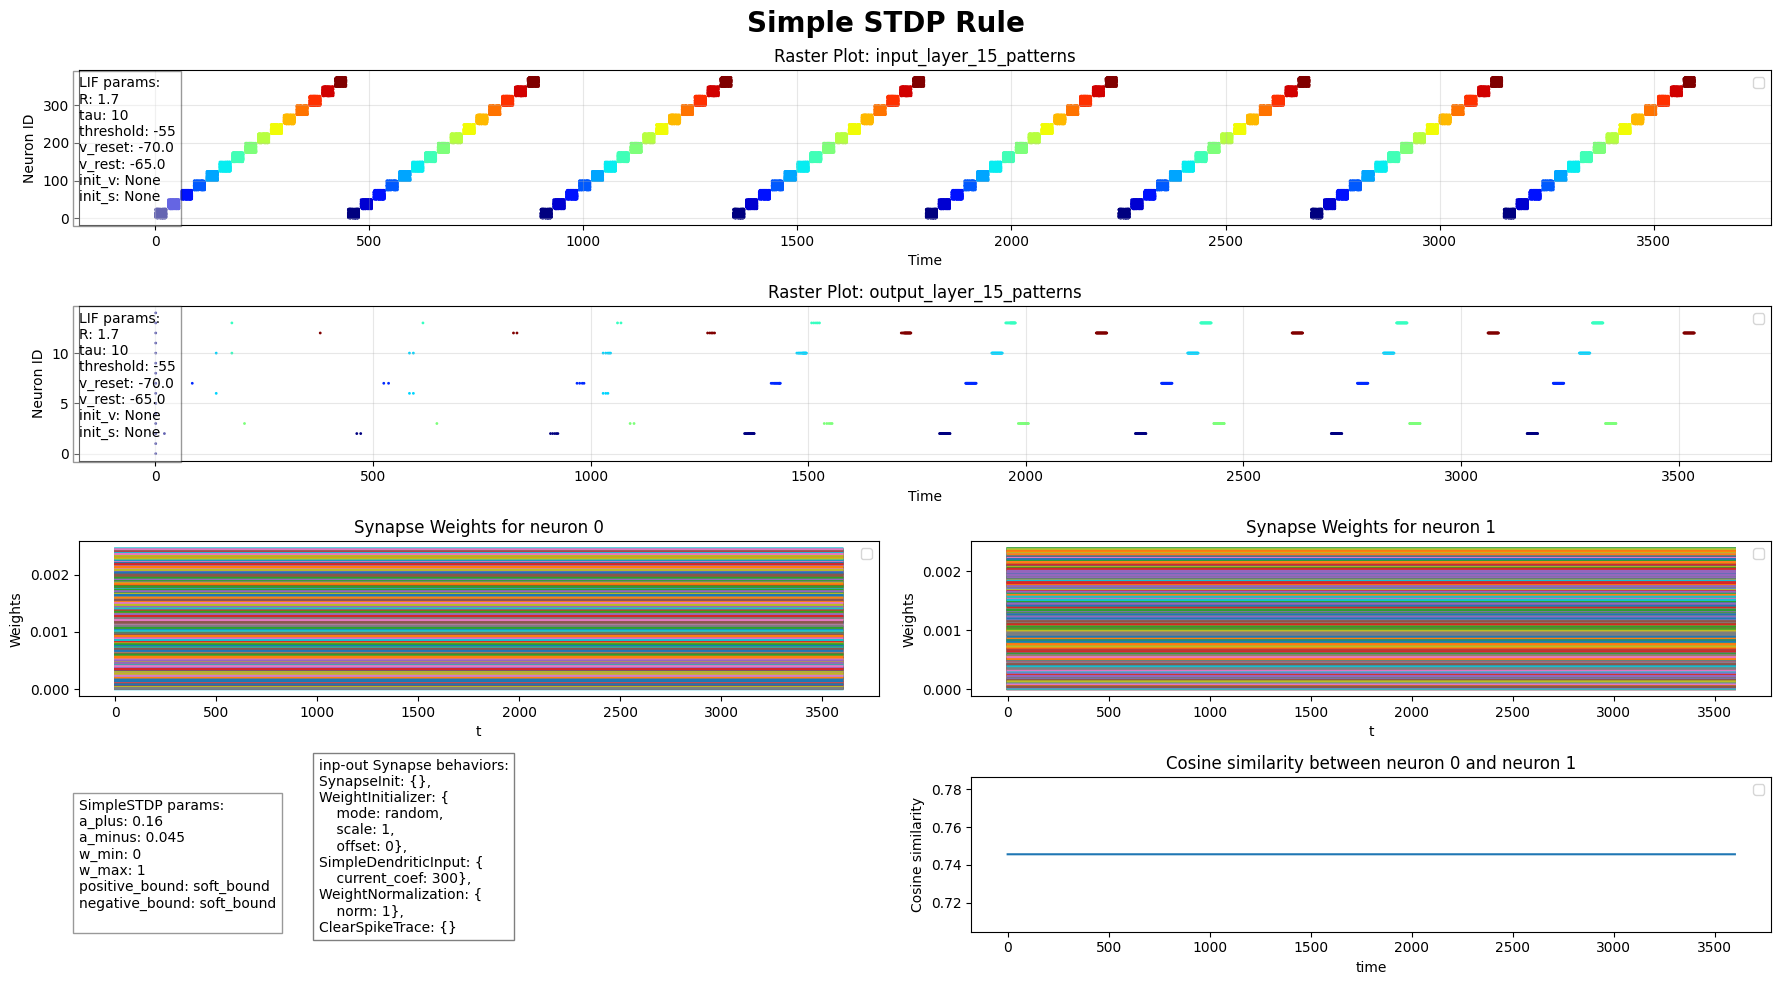

In [209]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


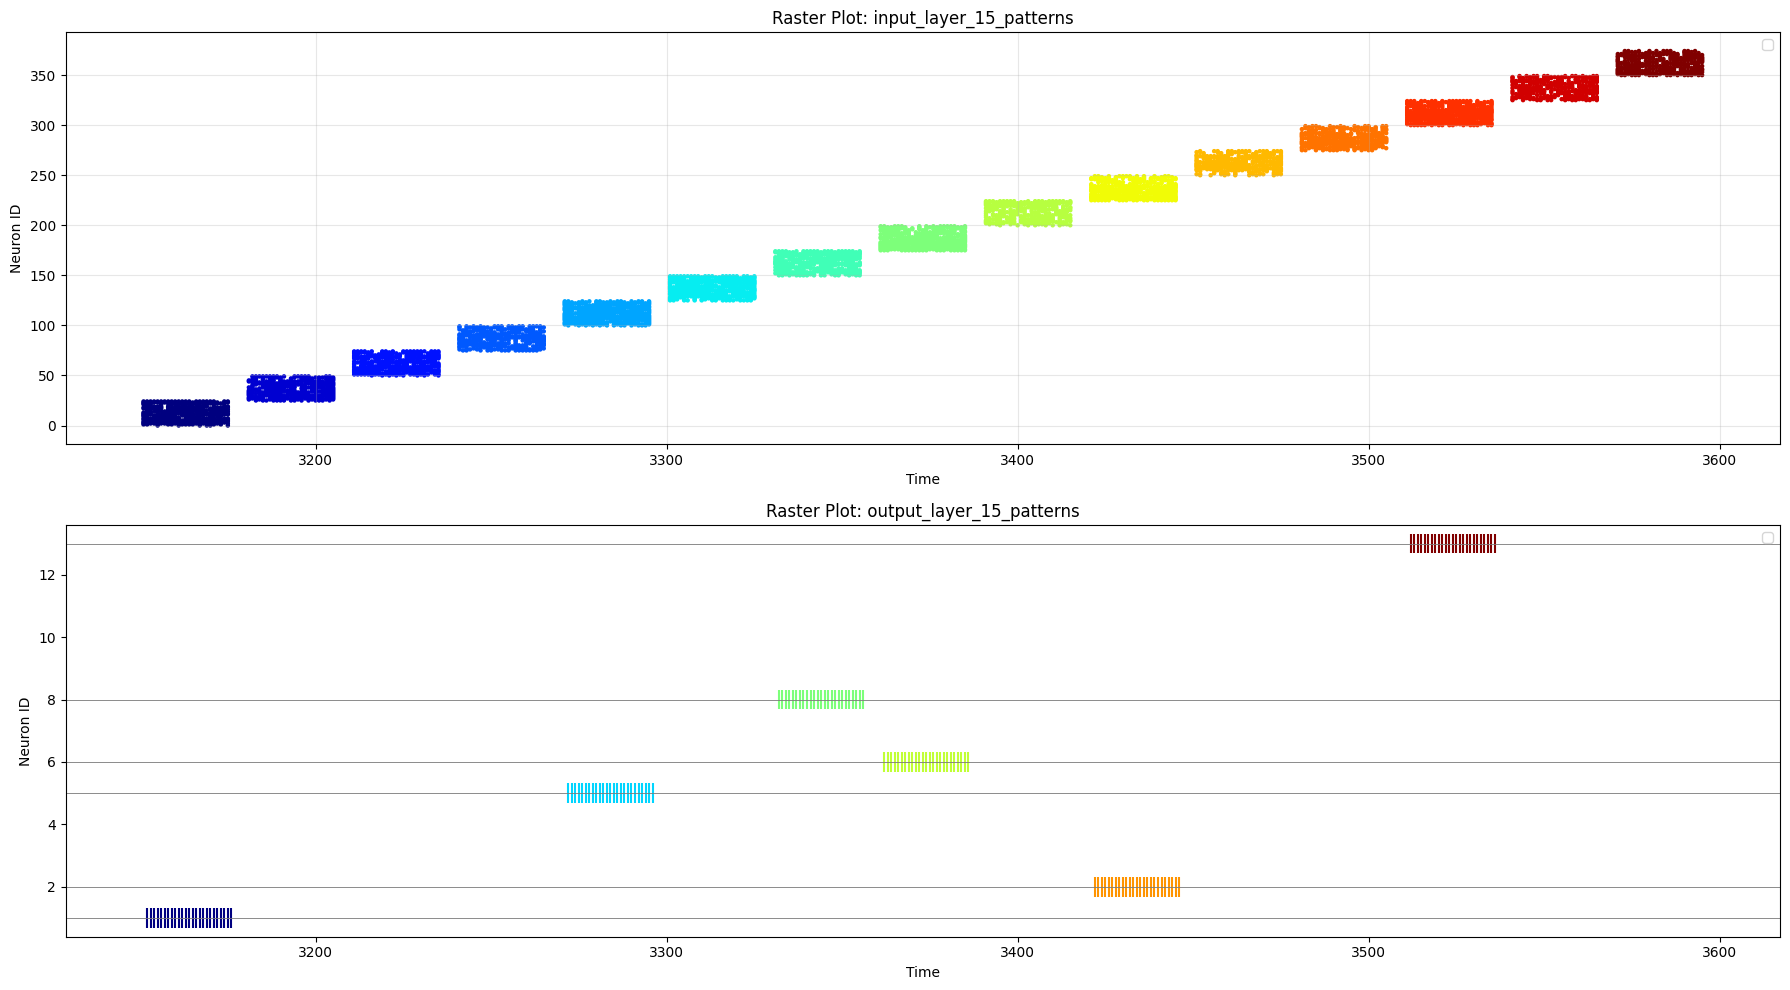

In [214]:
simulations = [sim4]
for i, sim in enumerate(simulations):
    fig = plt.figure(figsize=(18, 10))

    output_layer_size = sim.net.NeuronGroups[1].size
    ax1 = fig.add_subplot(2, 1, 1)  # 3 rows, 1 column, first plot
    ax1.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax1, sim.net.NeuronGroups[0], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)

    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)  # 3 rows, 1 column, first plot
    # ax2.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax2, sim.net.NeuronGroups[1], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=200, axhline=True, marker='|')

    # fig.suptitle("Simple STDP on different number of patterns", fontsize=20, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f"../report/plots/with-normalization/part1-evaluation-simple-stdp-LI-KWTA-{output_layer_size}-patterns.pdf")
    plt.show()

# Lateral Inhibition + KWTA + Homeostasis

In [180]:
NUM_DATA = 2
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [181]:
sim1 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.18,
                          a_minus=0.055,
                          current_coef=300)
input_layer = sim1.net.NeuronGroups[0]
output_layer = sim1.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)
output_layer.add_behavior(key=341,
                          initialize=False,
                          behavior=ActivityBaseHomeostasis(activity_rate=0.5*INSTANCE_DURATION,
                                                           window_size=2*(INSTANCE_DURATION + SLEEP),
                                                           updating_rate=1,)
                          )
syn_inp_out = sim1.net.SynapseGroups[0]
syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim1.initialize()
sim1.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(827)|2 groups, Synapses: tensor(1654)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_2_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False,  True,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fals

### 10 patterns

In [185]:
NUM_DATA = 10
NUM_FEED = 10
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [186]:
sim2 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.035,
                          current_coef=300)
input_layer = sim2.net.NeuronGroups[0]
output_layer = sim2.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)
output_layer.add_behavior(key=341,
                          initialize=False,
                          behavior=ActivityBaseHomeostasis(activity_rate=(1/NUM_DATA)*INSTANCE_DURATION,
                                                           window_size=NUM_DATA*(INSTANCE_DURATION + SLEEP),
                                                           updating_rate=1,)
                          )
syn_inp_out = sim2.net.SynapseGroups[0]
syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim2.initialize()
sim2.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(835)|2 groups, Synapses: tensor(8350)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_10_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[ True,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         ...,
         [False, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


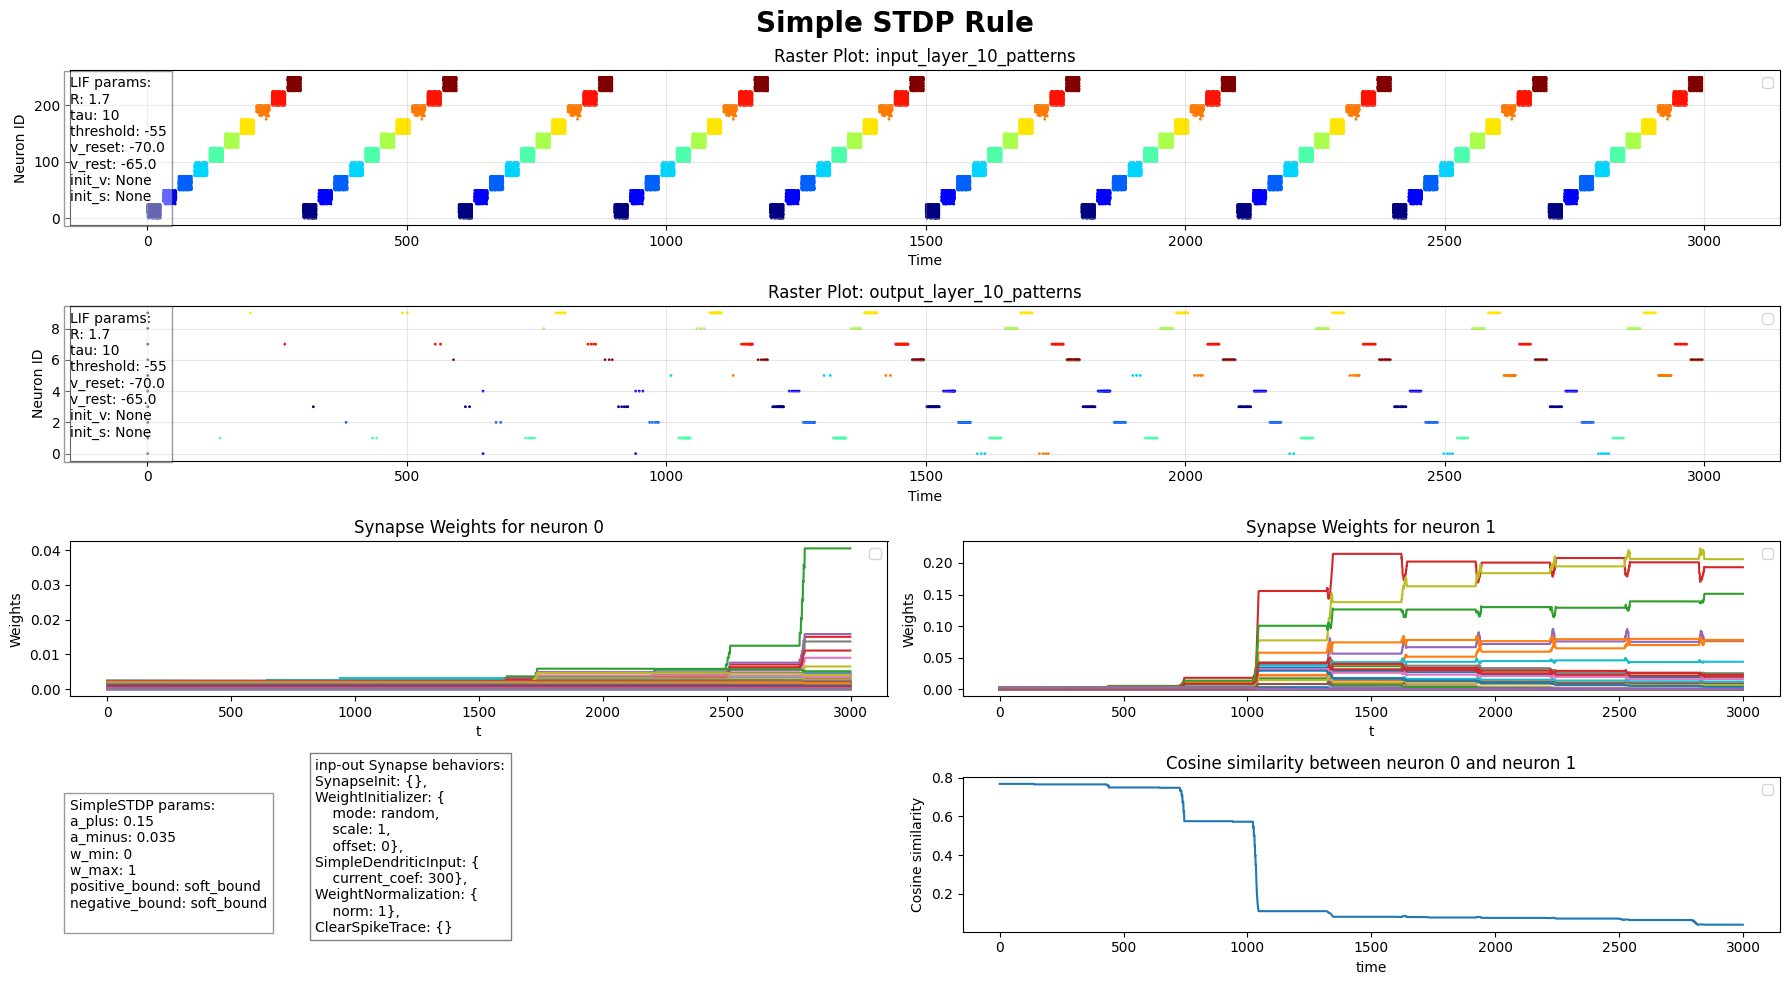

In [115]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2,sharex=ax1)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

### 20 patterns

In [140]:
NUM_DATA = 20
NUM_FEED = 8
INSTANCE_DURATION = 16
SLEEP = 4
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=4, resize_height=4, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [141]:
sim3 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.2,
                          a_minus=0.06,
                          current_coef=300)
input_layer = sim3.net.NeuronGroups[0]
output_layer = sim3.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)
output_layer.add_behavior(key=341,
                          initialize=False,
                          behavior=ActivityBaseHomeostasis(activity_rate=(1/NUM_DATA)*INSTANCE_DURATION,
                                                           window_size=NUM_DATA*(INSTANCE_DURATION + SLEEP),
                                                           updating_rate=1,)
                          )
syn_inp_out = sim3.net.SynapseGroups[0]
syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim3.initialize()
sim3.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(548)|2 groups, Synapses: tensor(10960)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_20_patterns', 'CustomNeuronGroup', 'ng'](528){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False,  True,  True,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fa

### 15 patterns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


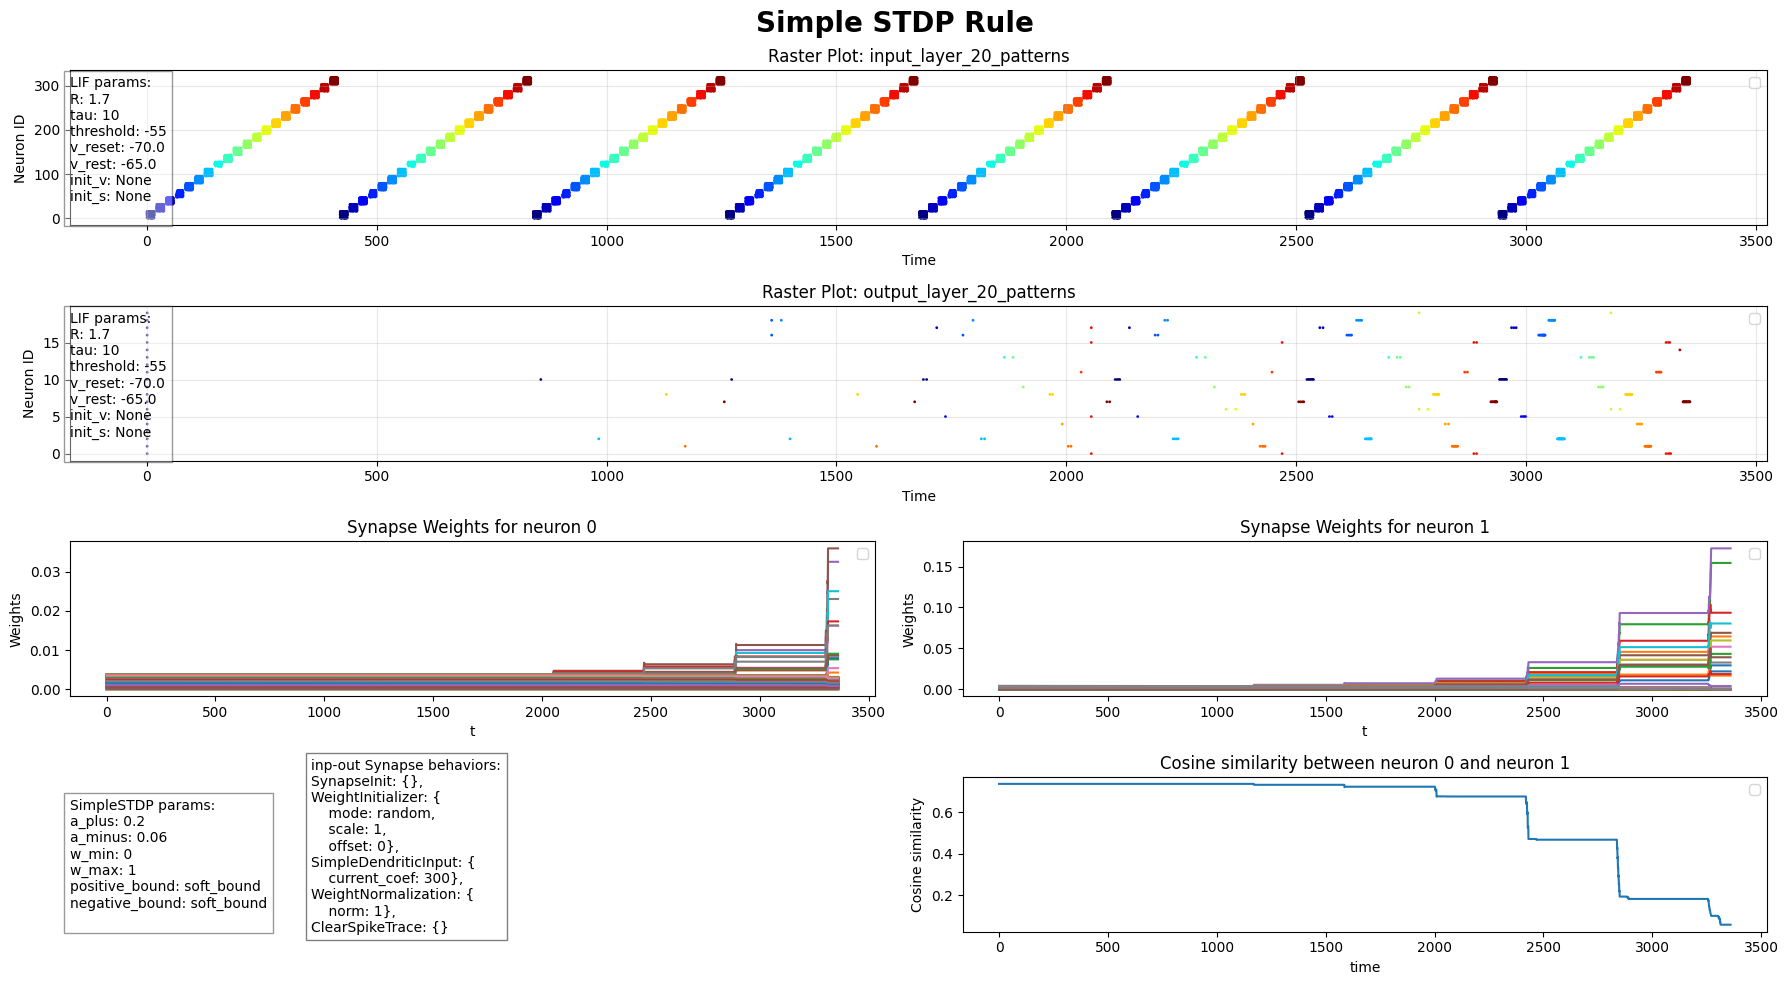

In [142]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2,sharex=ax1)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

In [164]:
NUM_DATA = 25
NUM_FEED = 8
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [165]:
sim4 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.035,
                          current_coef=500)
input_layer = sim4.net.NeuronGroups[0]
output_layer = sim4.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)
output_layer.add_behavior(key=341,
                          initialize=False,
                          behavior=ActivityBaseHomeostasis(activity_rate=(2/NUM_DATA)*INSTANCE_DURATION,
                                                           window_size=NUM_DATA*(INSTANCE_DURATION + SLEEP),
                                                           updating_rate=1,)
                          )
syn_inp_out = sim4.net.SynapseGroups[0]
syn_out_out = sim4.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=500.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim4.initialize()
sim4.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(850)|2 groups, Synapses: tensor(21250)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_25_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


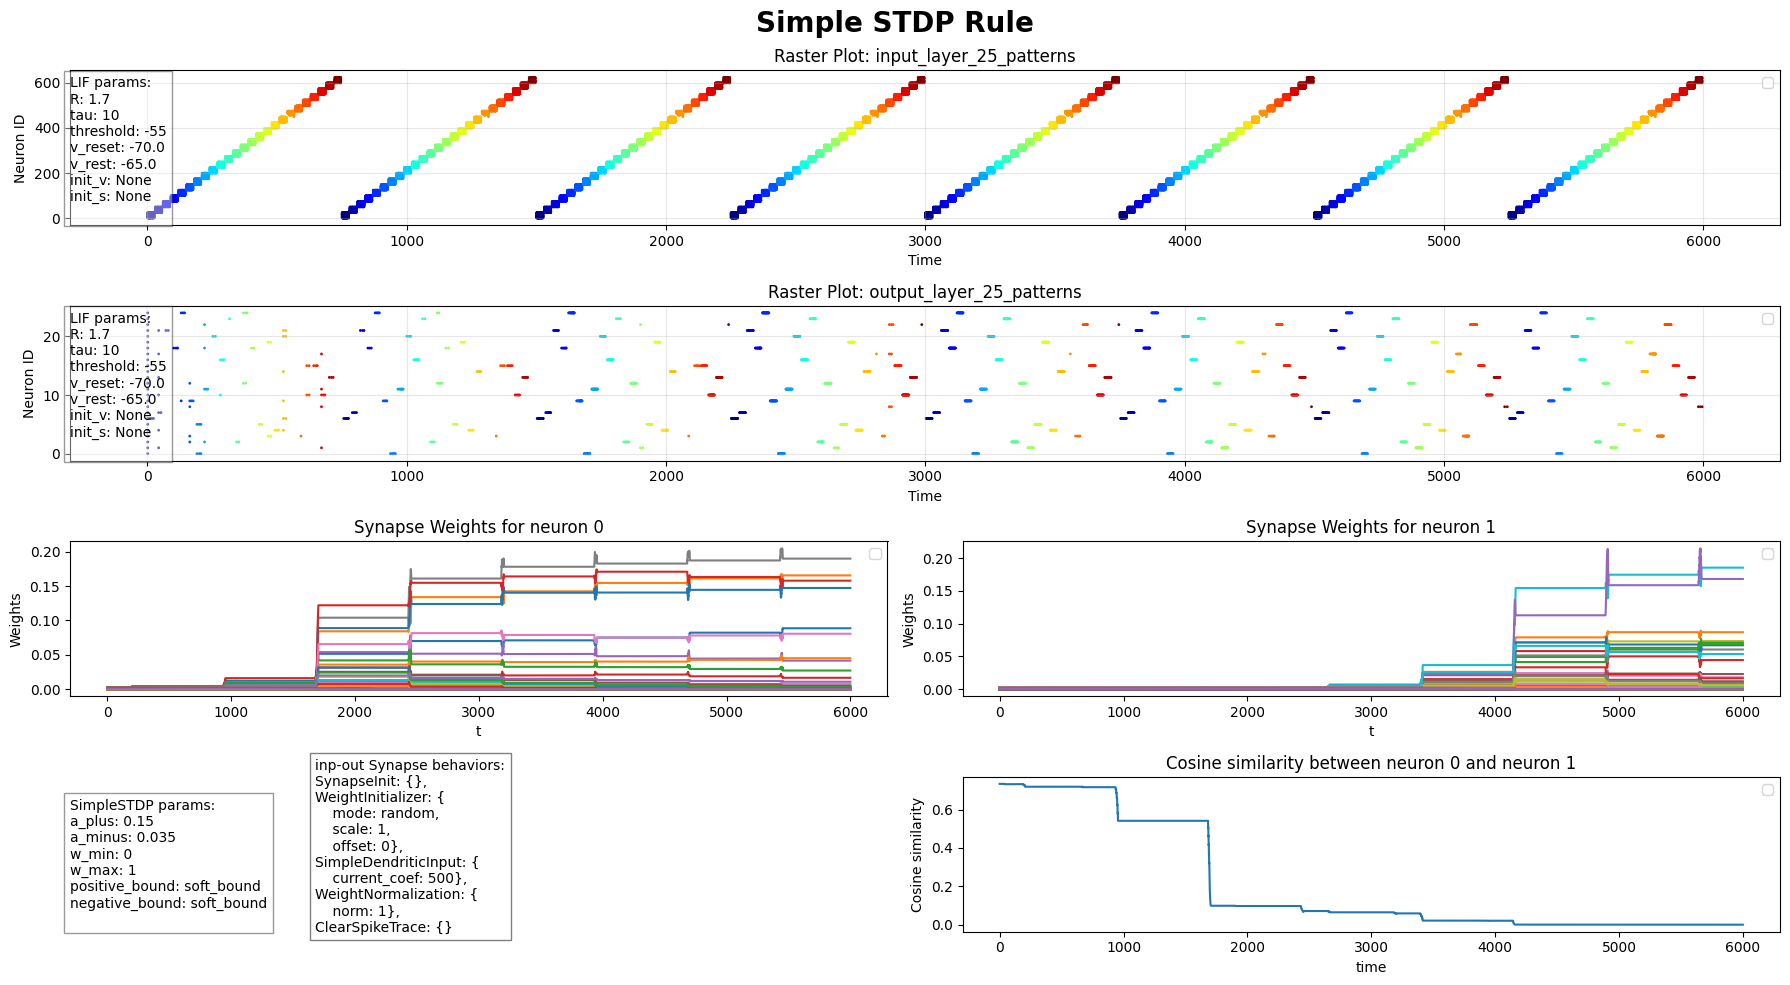

In [166]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)
ax1 = fig.add_subplot(4, 1, 1)  # 3 rows, 1 column, first plot
ax1.grid(True, alpha=0.3)
add_colorized_raset_plot(ax1, input_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2,sharex=ax1)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
add_colorized_raset_plot(ax2, output_layer, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0])
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(4, 2, 7)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

ax6 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

In [169]:
NUM_DATA = 30
NUM_FEED = 8
INSTANCE_DURATION = 25
SLEEP = 5
NUM_ITERATION = (INSTANCE_DURATION + SLEEP) * NUM_FEED * NUM_DATA
dataset = load_data(directory='../dataset/all-images', resize_width=5, resize_height=5, img_formats=(".tif",))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
dataset = dataset[:NUM_DATA, :]
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=1.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [170]:
sim5 = default_simulation(encoded_dataset=encoded_dataset,
                          num_feed=NUM_FEED,
                          instance_duration=INSTANCE_DURATION,
                          sleep=SLEEP,
                          input_layer_tag=f'input_layer_{NUM_DATA}_patterns',
                          output_layer_tag=f'output_layer_{NUM_DATA}_patterns',
                          normalization=True,
                          a_plus=0.15,
                          a_minus=0.035,
                          current_coef=500)
input_layer = sim5.net.NeuronGroups[0]
output_layer = sim5.net.NeuronGroups[1]
output_layer.add_behavior(key=400, behavior=KWTA(k=1), initialize=False)
output_layer.add_behavior(key=341,
                          initialize=False,
                          behavior=ActivityBaseHomeostasis(activity_rate=(3/NUM_DATA)*INSTANCE_DURATION,
                                                           window_size=NUM_DATA*(INSTANCE_DURATION + SLEEP),
                                                           updating_rate=1,)
                          )
syn_inp_out = sim5.net.SynapseGroups[0]
syn_out_out = sim5.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=500.,
                                                                  inhibitory=True),
                         initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I", "weights"], tag="syn_inp_out_rec"))
sim5.initialize()
sim5.simulate_iterations(iterations=NUM_ITERATION)

Network['Neocortex'](Neurons: tensor(855)|2 groups, Synapses: tensor(25650)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer_30_patterns', 'CustomNeuronGroup', 'ng'](825){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10,threshold=-55,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, Fa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


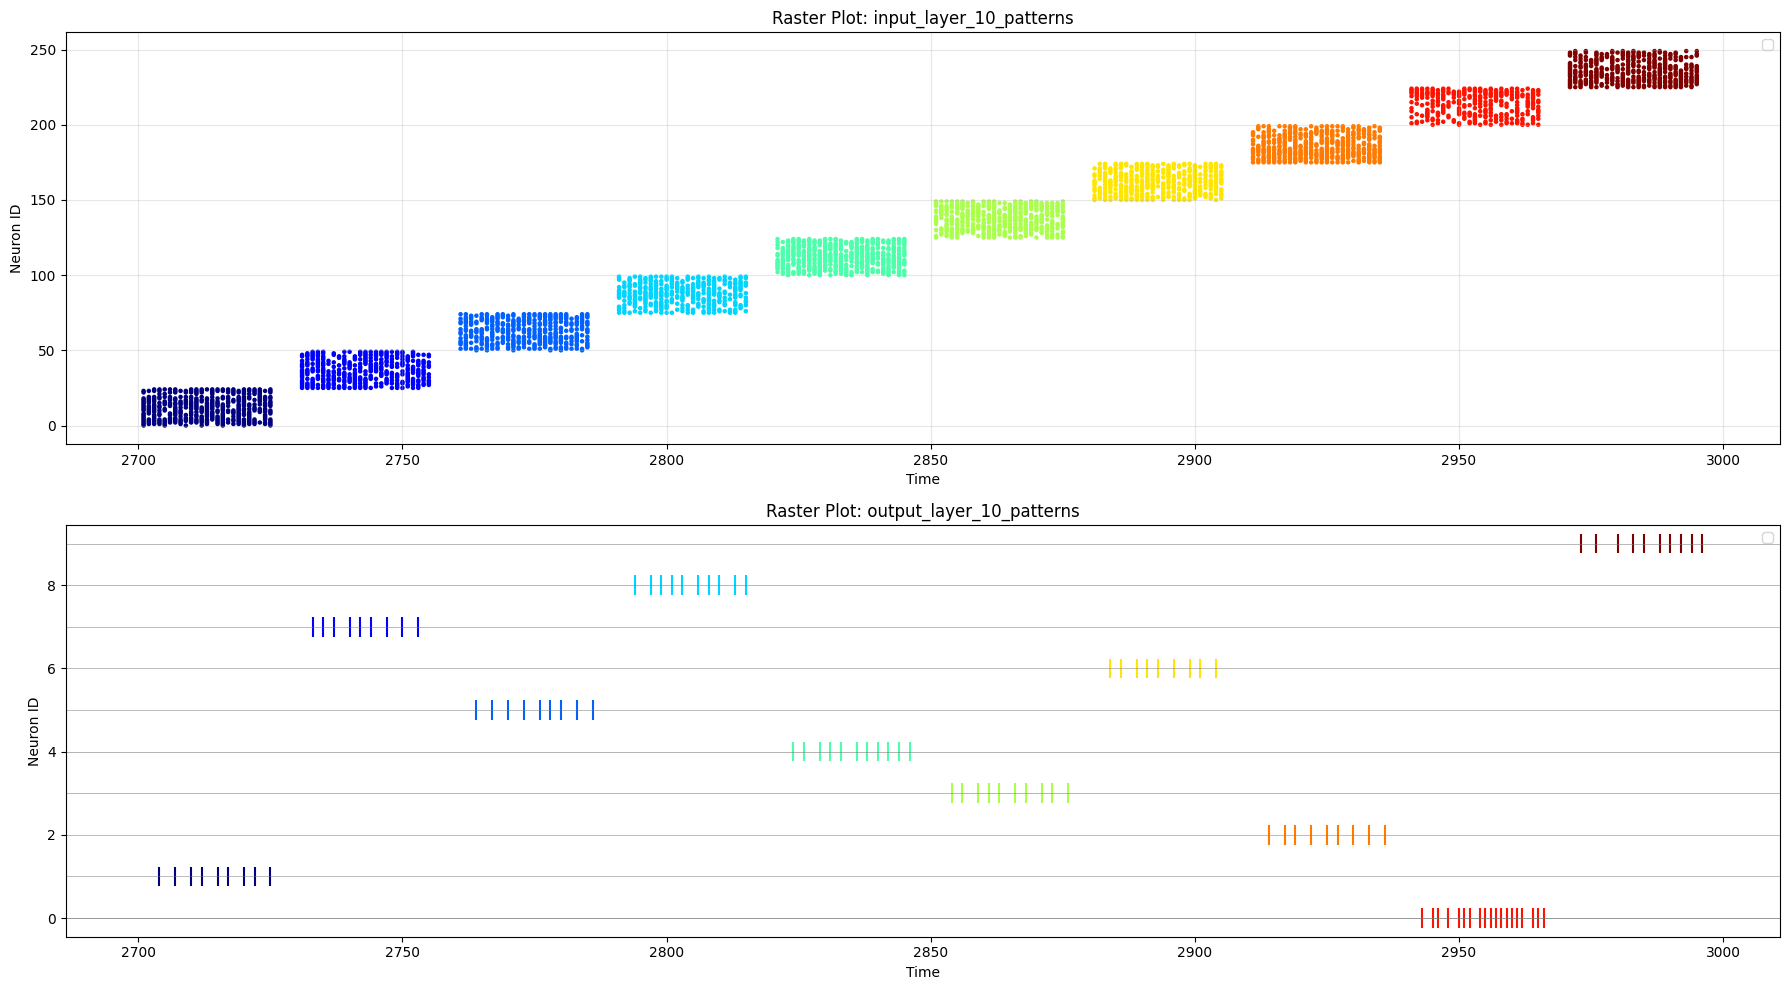

In [188]:
simulations = [sim1, sim2, sim3, sim4, sim5]
for i, sim in enumerate(simulations):
    fig = plt.figure(figsize=(18, 10))

    output_layer_size = sim.net.NeuronGroups[1].size
    ax1 = fig.add_subplot(2, 1, 1)  # 3 rows, 1 column, first plot
    ax1.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax1, sim.net.NeuronGroups[0], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=5)

    ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)  # 3 rows, 1 column, first plot
    # ax2.grid(True, alpha=0.3)
    add_colorized_raset_plot(ax2, sim.net.NeuronGroups[1], start_iteration=sim.net.iteration - output_layer_size*(INSTANCE_DURATION+SLEEP), end_iteration=sim.net.iteration, time_window=INSTANCE_DURATION+SLEEP, num_data=dataset.shape[0], s=400/output_layer_size, axhline=True, marker='|')

    # fig.suptitle("Simple STDP on different number of patterns", fontsize=20, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f"../report/plots/with-normalization/part1-evaluation-simple-stdp-LI-KWTA-Homeostasis-{output_layer_size}-patterns.pdf")
    plt.show()